<a href="https://colab.research.google.com/github/kthhtk/AIFFEL_Quest_cr/blob/master/Project/03/10_2_project01_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf                                              # 텐서플로우 라이브러리 임포트
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # 이미지 데이터 증강을 위한 ImageDataGenerator 임포트

import os                                                            # 파일/디렉토리 조작을 위한 os 모듈 임포트
import numpy as np                                                   # 수치 연산을 위한 numpy 라이브러리 임포트
import matplotlib.pyplot as plt                                      # 시각화를 위한 matplotlib 라이브러리 임포트

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'  # 고양이와 강아지 이미지 데이터셋이 저장된 URL

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)  # URL에서 데이터셋을 다운로드하고 압축 해제

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')  # 압축 해제된 데이터셋의 경로 설정

68606236/68606236 [==============================] - 0s 0us/step


In [6]:
train_dir = os.path.join(path, 'train')          # 학습용 데이터셋 디렉토리 경로 설정
validation_dir = os.path.join(path, 'validation') # 검증용 데이터셋 디렉토리 경로 설정
print(train_dir)                                  # 학습 데이터 경로 출력
print(validation_dir)                             # 검증 데이터 경로 출력

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [7]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')     # 학습용 고양이 이미지가 있는 디렉토리 경로 설정
print(train_cats_dir)                                 # 학습용 고양이 이미지 경로 출력

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')     # 학습용 강아지 이미지가 있는 디렉토리 경로 설정
print(train_dogs_dir)                                 # 학습용 강아지 이미지 경로 출력

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')    # 검증용 고양이 이미지가 있는 디렉토리 경로 설정
print(validation_cats_dir)                                    # 검증용 고양이 이미지 경로 출력

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')    # 검증용 강아지 이미지가 있는 디렉토리 경로 설정
print(validation_dogs_dir)                                    # 검증용 강아지 이미지 경로 출력

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))                # 학습용 고양이 이미지 개수 계산
print('total training cat images:', num_cats_tr)             # 학습용 고양이 이미지 수 출력

num_dogs_tr = len(os.listdir(train_dogs_dir))                # 학습용 강아지 이미지 개수 계산
print('total training dog images:', num_dogs_tr)             # 학습용 강아지 이미지 수 출력

print("--")                                                  # 구분선 출력

num_cats_val = len(os.listdir(validation_cats_dir))          # 검증용 고양이 이미지 개수 계산
print('total validation cat images:', num_cats_val)          # 검증용 고양이 이미지 수 출력

num_dogs_val = len(os.listdir(validation_dogs_dir))          # 검증용 강아지 이미지 개수 계산
print('total validation dog images:', num_dogs_val)          # 검증용 강아지 이미지 수 출력

print("--")                                                  # 구분선 출력

total_train = num_cats_tr + num_dogs_tr                      # 전체 학습 이미지 개수 계산
print("Total training images:", total_train)                 # 전체 학습 이미지 수 출력

total_val = num_cats_val + num_dogs_val                      # 전체 검증 이미지 개수 계산
print("Total validation images:", total_val)                 # 전체 검증 이미지 수 출력

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [78]:
# 모델 학습을 위한 하이퍼파라미터 설정
batch_size = 16    # 한 번에 처리할 이미지 개수
epochs = 5         # 전체 데이터셋 반복 학습 횟수
IMG_HEIGHT = 64   # 입력 이미지의 세로 크기 (픽셀)
IMG_WIDTH = 64    # 입력 이미지의 가로 크기 (픽셀)

In [79]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))    # 1행 5열의 서브플롯 생성, 전체 figure 크기는 10x10
    axes = axes.flatten()                               # 2차원 배열을 1차원으로 평탄화
    for img, ax in zip(images_arr, axes):              # 이미지와 축을 순회하면서
        ax.imshow(img)                                 # 이미지 표시
        ax.axis('off')                                 # 축 눈금 제거
    plt.tight_layout()                                 # 서브플롯 간격 자동 조정
    plt.show()                                         # 그래프 출력

In [80]:
# Training data generator
image_gen_train = ImageDataGenerator(
    rescale=1./255,                # 픽셀값을 0~1 사이로 정규화
    rotation_range=0.3,            # 이미지 회전 범위 (30%)
    width_shift_range=0.1,         # 가로 방향 이동 범위 (10%)
    height_shift_range=0.1,        # 세로 방향 이동 범위 (10%)
    zoom_range=0.2,                # 확대/축소 범위 (20%)
    horizontal_flip=True,          # 좌우 반전 허용
    vertical_flip=False            # 상하 반전 비허용
)

In [53]:
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,                          # 배치 크기 설정
    directory=train_dir,                            # 학습 데이터가 있는 디렉토리 경로
    shuffle=True,                                   # 데이터 랜덤 섞기 활성화
    target_size=(IMG_HEIGHT, IMG_WIDTH),            # 입력 이미지 크기 조정 (256x256)
    class_mode='binary'                             # 이진 분류 모드 설정 (고양이/강아지)
)

Found 2000 images belonging to 2 classes.


In [52]:
train_data_gen[0][0].shape    # (배치크기, 높이, 너비, 채널) 형태의 텐서 구조 반환

(16, 64, 64, 3)

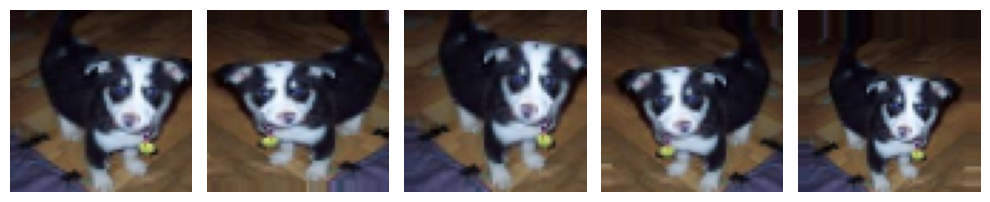

In [57]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]    # 첫 번째 배치의 첫 번째 이미지를 5번 데이터 증강하여 리스트로 생성
plotImages(augmented_images)                                       # 증강된 5개의 이미지를 시각화

In [58]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)    # 검증 데이터는 정규화만 수행 (1/255로 스케일링하여 0~1 사이 값으로 변환)

In [59]:
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,                          # 배치 크기 설정
    directory=validation_dir,                       # 검증 데이터가 있는 디렉토리 경로
    target_size=(IMG_HEIGHT, IMG_WIDTH),           # 입력 이미지 크기를 조정
    class_mode='binary'                            # 이진 분류(고양이/강아지) 모드 설정
)

Found 1000 images belonging to 2 classes.


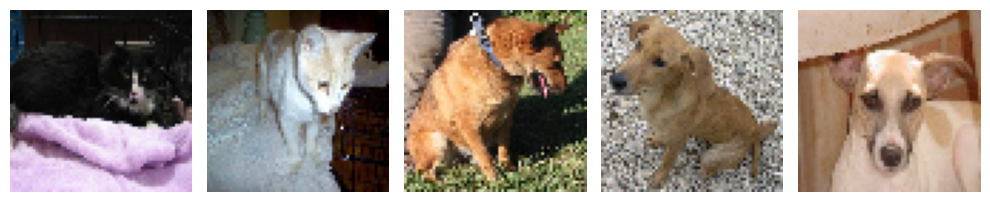

In [60]:
sample_training_images, _ = next(val_data_gen)     # 검증 데이터 생성기에서 다음 배치를 가져옴 (이미지와 레이블, 레이블은 _ 로 무시)
plotImages(sample_training_images[:5])             # 배치에서 처음 5개 이미지를 시각화하여 출력

In [61]:
_[:5]    # 입력 데이터의 처음 5개 요소만 선택 (슬라이싱) - Conv-64, Conv-64, MaxPool, Conv-128, Conv-128

array([0., 0., 1., 1., 1.], dtype=float32)

In [19]:
# import tensorflow as tf

# # VGG16 모델 구현 - 이진 분류 버전
# # 입력층 정의 - 256x256x3 크기의 RGB 이미지 입력
# input_layer = tf.keras.layers.Input(shape=(256, 256, 3))    # 입력 이미지의 크기와 채널 수 정의

# # Block 1: 첫 번째 Conv-64 블록
# x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)    # 64개의 3x3 필터, ReLU 활성화
# x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)              # 64개의 3x3 필터, ReLU 활성화
# x = tf.keras.layers.BatchNormalization()(x)                                               # 배치 정규화로 학습 안정화
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                              # 2x2 맥스풀링으로 특징맵 크기 축소

# # Block 2: Conv-128 블록
# x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)            # 128개의 3x3 필터
# x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)            # 128개의 3x3 필터
# x = tf.keras.layers.BatchNormalization()(x)                                              # 배치 정규화
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                             # 2x2 맥스풀링

# # Block 3: Conv-256 블록
# x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)            # 256개의 3x3 필터
# x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)            # 256개의 3x3 필터
# x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)            # 256개의 3x3 필터
# x = tf.keras.layers.BatchNormalization()(x)                                              # 배치 정규화
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                             # 2x2 맥스풀링

# # Block 4: 첫 번째 Conv-512 블록
# x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)            # 512개의 3x3 필터
# x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)            # 512개의 3x3 필터
# x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)            # 512개의 3x3 필터
# x = tf.keras.layers.BatchNormalization()(x)                                              # 배치 정규화
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                             # 2x2 맥스풀링

# # Block 5: 두 번째 Conv-512 블록
# x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)            # 512개의 3x3 필터
# x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)            # 512개의 3x3 필터
# x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)            # 512개의 3x3 필터
# x = tf.keras.layers.BatchNormalization()(x)                                              # 배치 정규화
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                             # 2x2 맥스풀링

# # 완전연결층 (Fully Connected Layers)
# x = tf.keras.layers.Flatten()(x)                                                         # 특징맵을 1차원으로 펼침
# x = tf.keras.layers.Dense(4096, activation='relu')(x)                                    # 4096 뉴런의 완전연결층
# x = tf.keras.layers.Dense(4096, activation='relu')(x)                                    # 4096 뉴런의 완전연결층
# out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)                            # 이진 분류를 위한 출력층 (1개 뉴런, sigmoid 활성화)

# # 모델 생성 및 요약
# model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])                        # 모델 구조 정의
# model.summary()                                                                          # 모델 구조 출력

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856 

In [63]:
#모델 경량화

# 입력층 정의 - 더 작은 입력 크기 사용
input_layer = tf.keras.layers.Input(shape=(64, 64, 3))    # 입력 크기를 더 축소

# Block 1
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)    # 필터 수 감소
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Block 2
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Block 3
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Block 4
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# 완전연결층
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# 모델 생성
model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 64)        1849

In [64]:
# 모델 컴파일 설정
loss_function=tf.keras.losses.binary_crossentropy    # 이진 분류를 위한 손실 함수 설정
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)    # Adam 옵티마이저, 학습률 0.01로 설정
metric=tf.keras.metrics.binary_accuracy    # 이진 분류 정확도를 평가 지표로 설정

# 모델 컴파일
model.compile(loss=loss_function,          # 손실 함수 지정
              optimizer=optimize,           # 옵티마이저 지정
              metrics=[metric])            # 평가 지표 지정

# TensorBoard 콜백 설정 (선택사항)
# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]    # TensorBoard를 통한 학습 과정 시각화 설정
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [66]:
# 모델 학습 실행
history = model.fit(
      train_data_gen,                                                                     # 학습 데이터 생성기
      steps_per_epoch=int((len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size),    # 한 에포크당 학습 스텝 수 (전체 이미지 수/배치 크기)를 정수로 변환
      epochs=epochs,                                                                      # 학습 반복 횟수
      validation_data=val_data_gen,                                                       # 검증용 데이터 생성기
      # callbacks=callbacks_list,                                                         # 콜백 함수 (현재 비활성화)
      validation_freq=1)                                                                  # 검증 수행 주기 (매 에포크마다)

Epoch 1/5
125/125 [==============================] - 12s 88ms/step - loss: 0.7781 - binary_accuracy: 0.4865 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 10s 82ms/step - loss: 0.6937 - binary_accuracy: 0.4980 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 10s 81ms/step - loss: 0.6934 - binary_accuracy: 0.4940 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 10s 81ms/step - loss: 0.6937 - binary_accuracy: 0.4890 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 10s 81ms/step - loss: 0.6936 - binary_accuracy: 0.5010 - val_loss: 0.6932 - val_binary_accuracy: 0.5000


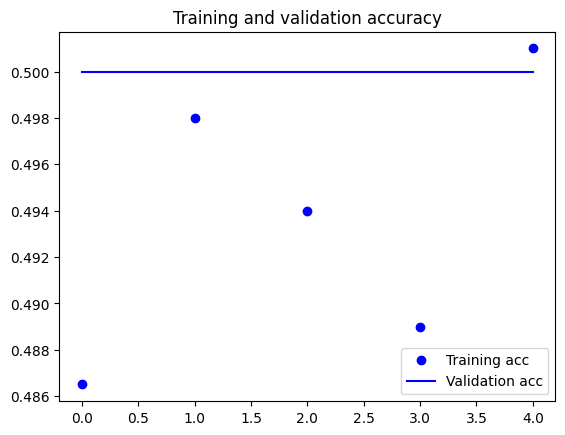

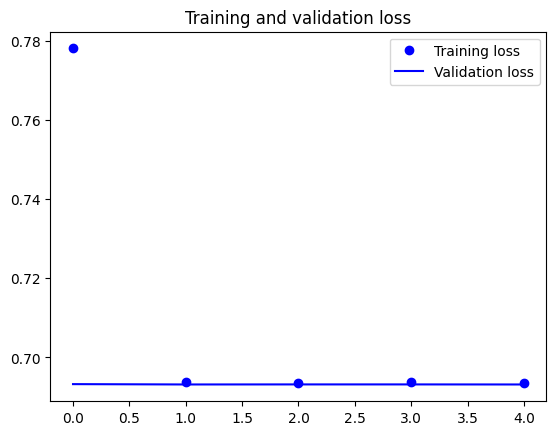

In [68]:
# 학습 과정의 정확도와 손실값 기록을 추출
acc = history.history['binary_accuracy']              # 학습 데이터에 대한 정확도 기록 추출
val_acc = history.history['val_binary_accuracy']      # 검증 데이터에 대한 정확도 기록 추출
loss = history.history['loss']                        # 학습 데이터에 대한 손실값 기록 추출
val_loss = history.history['val_loss']                # 검증 데이터에 대한 손실값 기록 추출

epochs_range = range(len(acc))                        # x축 범위를 전체 에포크 수로 설정

# 첫 번째 그래프: 정확도 곡선
plt.plot(epochs_range, acc, 'bo', label='Training acc')       # 학습 정확도를 파란 점으로 표시
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')  # 검증 정확도를 파란 선으로 표시
plt.title('Training and validation accuracy')                  # 정확도 그래프 제목
plt.legend()                                                  # 범례 표시

plt.figure()                                                  # 새로운 그래프 창 생성

# 두 번째 그래프: 손실값 곡선
plt.plot(epochs_range, loss, 'bo', label='Training loss')     # 학습 손실값을 파란 점으로 표시
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')# 검증 손실값을 파란 선으로 표시
plt.title('Training and validation loss')                     # 손실값 그래프 제목
plt.legend()                                                  # 범례 표시

plt.show()                                                    # 그래프 출력

In [82]:
# 문제 1-2. hyperparameter 설정
batch_size = 3  # 배치 크기 설정
epochs = 3  # 전체 학습 반복 횟수
learning_rate = 0.001  # 학습률
img_height = 64  # 입력 이미지 높이
img_width = 64  # 입력 이미지 너비

In [81]:
# 문제 1-2. 데이터 generator 생성
train_datagen = ImageDataGenerator(
    rescale=1./255,                # 입력 이미지의 픽셀값을 0~1 사이로 정규화
    rotation_range=20,             # 무작위로 이미지를 ±20도 범위에서 회전
    width_shift_range=0.2,         # 가로 방향으로 전체 너비의 20% 범위에서 이동
    height_shift_range=0.2,        # 세로 방향으로 전체 높이의 20% 범위에서 이동
    horizontal_flip=True,          # 좌우 대칭 변환 적용
    fill_mode='nearest'            # 이미지 변환 시 생기는 빈 공간을 가장 가까운 픽셀값으로 채움
)

validation_datagen = ImageDataGenerator(rescale=1./255)    # 검증 데이터는 정규화만 수행하여 과적합 방지

# 학습 데이터 generator 설정
train_data_gen = train_datagen.flow_from_directory(
    train_dir,                                  # 학습 데이터가 있는 디렉토리 경로
    target_size=(IMG_HEIGHT, IMG_WIDTH),        # 모든 이미지를 지정된 크기로 리사이즈
    batch_size=batch_size,                      # 한 번에 생성할 배치 크기
    class_mode='binary'                         # 이진 분류를 위한 레이블 형식 지정
)

# 검증 데이터 generator 설정
val_data_gen = validation_datagen.flow_from_directory(
    validation_dir,                             # 검증 데이터가 있는 디렉토리 경로
    target_size=(IMG_HEIGHT, IMG_WIDTH),        # 모든 이미지를 지정된 크기로 리사이즈
    batch_size=batch_size,                      # 한 번에 생성할 배치 크기
    class_mode='binary'                         # 이진 분류를 위한 레이블 형식 지정
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [83]:
# 문제 1-2. 모델 구현
# VGG16 네트워크 구조 구현
input_layer = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))    # 입력층 정의: (높이, 너비, 채널)

# Conv-64 블록: 2개의 Conv2D 층과 MaxPooling
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)    # 첫 번째 Conv 층: 64개 필터
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)              # 두 번째 Conv 층: 64개 필터
x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                               # 특징맵 크기를 절반으로 축소

# Conv-128 블록: 2개의 Conv2D 층과 MaxPooling
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)             # 첫 번째 Conv 층: 128개 필터
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)             # 두 번째 Conv 층: 128개 필터
x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                               # 특징맵 크기를 절반으로 축소

# Conv-256 블록: 3개의 Conv2D 층과 MaxPooling
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)             # 첫 번째 Conv 층: 256개 필터
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)             # 두 번째 Conv 층: 256개 필터
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)             # 세 번째 Conv 층: 256개 필터
x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                               # 특징맵 크기를 절반으로 축소

# 첫 번째 Conv-512 블록: 3개의 Conv2D 층과 MaxPooling
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)             # 첫 번째 Conv 층: 512개 필터
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)             # 두 번째 Conv 층: 512개 필터
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)             # 세 번째 Conv 층: 512개 필터
x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                               # 특징맵 크기를 절반으로 축소

# 두 번째 Conv-512 블록: 3개의 Conv2D 층과 MaxPooling
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)             # 첫 번째 Conv 층: 512개 필터
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)             # 두 번째 Conv 층: 512개 필터
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)             # 세 번째 Conv 층: 512개 필터
x = tf.keras.layers.MaxPooling2D((2, 2))(x)                                               # 특징맵 크기를 절반으로 축소

# Fully Connected Layers (완전연결층)
x = tf.keras.layers.Flatten()(x)                                                          # 특징맵을 1차원으로 평탄화
x = tf.keras.layers.Dense(4096, activation='relu')(x)                                     # 첫 번째 FC층: 4096 뉴런
x = tf.keras.layers.Dense(4096, activation='relu')(x)                                     # 두 번째 FC층: 4096 뉴런
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)                             # 출력층: 이진분류를 위한 시그모이드 활성화

# 모델 생성 및 구조 출력
model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])                         # 모델 정의
model.summary()                                                                           # 모델 구조 요약 출력

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 32, 128)       147584    
                                                           

In [85]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
loss_function = tf.keras.losses.binary_crossentropy    # 고양이/강아지 이진 분류를 위한 크로스 엔트로피 손실 함수
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    # 학습률이 적용된 Adam 옵티마이저로 모델 파라미터 최적화
metric = tf.keras.metrics.binary_accuracy    # 이진 분류 문제의 정확도를 측정하는 평가 지표

# 모델 컴파일
model.compile(
    loss=loss_function,          # 모델 학습 시 최소화할 손실 함수 지정
    optimizer=optimizer,         # 모델 파라미터를 업데이트할 옵티마이저 지정
    metrics=[metric]            # 학습 과정에서 측정할 평가 지표 지정
)

In [86]:
# 모델 학습
history = model.fit(
      train_data_gen,                                                                     # 학습 데이터 생성기
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,    # 한 에포크당 학습 스텝 수 (고양이 이미지 수 + 강아지 이미지 수)/배치크기
      epochs=epochs,                                                                      # 전체 데이터셋 반복 학습 횟수
      validation_data=val_data_gen,                                                       # 검증용 데이터 생성기
      # callbacks=callbacks_list,                                                         # 콜백 함수 (현재 비활성화)
      validation_freq=1)                                                                  # 매 에포크마다 검증 수행

Epoch 1/3


KeyboardInterrupt: 

##학습이 너무 오래걸려서 코랩에서 진행할수가 없어, lms의 스샷을 가져옴

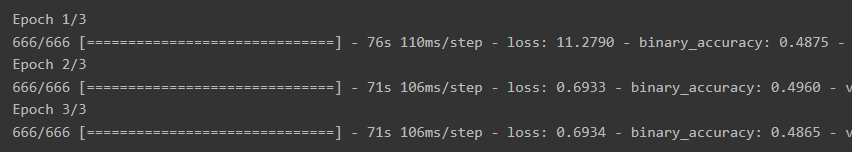

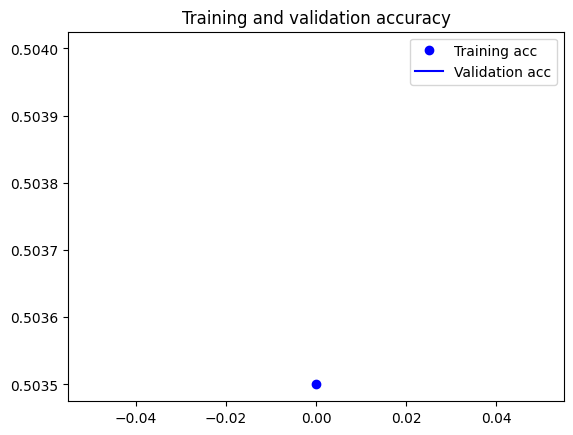

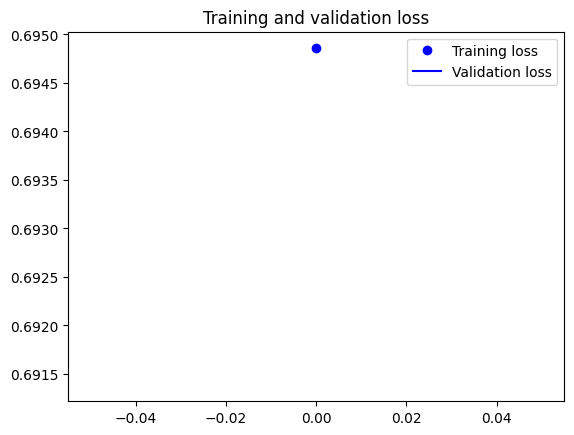

In [87]:
# 학습 과정에서의 정확도와 손실값 기록 추출
acc = history.history['binary_accuracy']              # 학습 정확도 기록 추출
val_acc = history.history['val_binary_accuracy']      # 검증 정확도 기록 추출
loss = history.history['loss']                        # 학습 손실값 기록 추출
val_loss = history.history['val_loss']                # 검증 손실값 기록 추출

epochs_range = range(len(acc))                        # x축 범위를 전체 에포크 수로 설정

# 첫 번째 그래프: 정확도 시각화
plt.plot(epochs_range, acc, 'bo', label='Training acc')       # 학습 정확도를 파란 점으로 표시
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')  # 검증 정확도를 파란 실선으로 표시
plt.title('Training and validation accuracy')                  # 정확도 그래프 제목 설정
plt.legend()                                                  # 범례 표시

plt.figure()                                                  # 새로운 그래프 창 생성

# 두 번째 그래프: 손실값 시각화
plt.plot(epochs_range, loss, 'bo', label='Training loss')     # 학습 손실값을 파란 점으로 표시
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')# 검증 손실값을 파란 실선으로 표시
plt.title('Training and validation loss')                     # 손실값 그래프 제목 설정
plt.legend()                                                  # 범례 표시

plt.show()                                                    # 그래프 출력

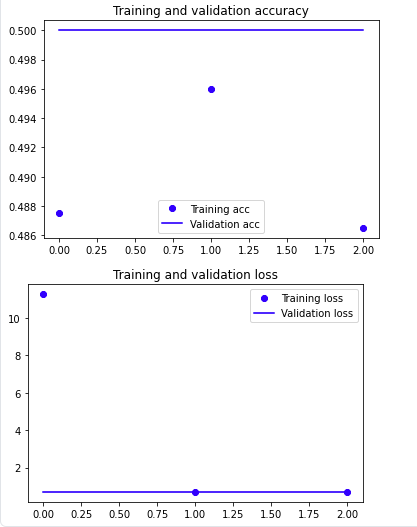

#회고

코랩에서 학습시키는 속도가 너무너무너무너무 느려서 도저히 여기서는 진행할 수가 없었다.

그래서, 아이펠 lms 에서 실행한 결과본을 스샷으로 붙여넣었다.

lms 에서도 모델 사이즈가 커지고 하이퍼 파라미터의 사이즈를 키우면 학습시간이 너무 늘어나 오래걸렸기에, 시간관계상 오히려 축소해서 테스트해볼수 밖에 없었다.
